In [3]:
import fastai.vision.all
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import time

In [4]:
path= fastai.vision.all.untar_data(fastai.vision.all.URLs.CIFAR)
# dblock= fastai.vision.all.DataBlock(blocks=(fastai.vision.all.ImageBlock(), fastai.vision.all.CategoryBlock()),
#                                     get_items=fastai.vision.all.get_image_files,
#                                     get_y=fastai.vision.all.parent_label,
#                                     item_tfms=fastai.vision.all.Resize(460),
#                                     batch_tfms=fastai.vision.all.aug_transforms(size=124, min_scale=0.75) )
dblock= fastai.vision.all.DataBlock(blocks=(fastai.vision.all.ImageBlock(), fastai.vision.all.CategoryBlock()),
                                    get_items=fastai.vision.all.get_image_files,
                                    get_y=fastai.vision.all.parent_label )
dls= dblock.dataloaders(path, bs=64)  #, cpu=True
path, dls.n, dls.c, dls.train.one_batch()[0].shape

(Path('/home/akihikoy/.fastai/data/cifar10'),
 48000,
 10,
 torch.Size([64, 3, 32, 32]))

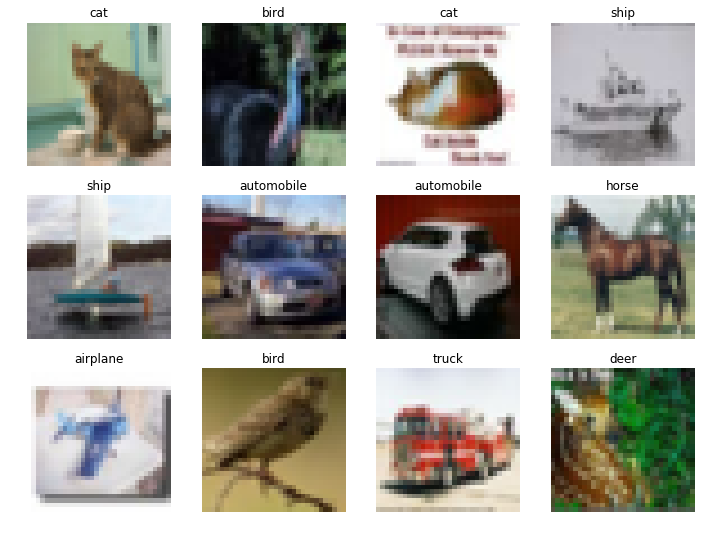

In [5]:
# x: Datasets
def show_grid(x, imgs, labels, ctxs=None, max_n=12, nrows=None, ncols=4, figsize=None, **kwargs):
    # if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = fastai.vision.all.get_grid(min(len(imgs), max_n), nrows=None, ncols=ncols, figsize=figsize)
    for ctx,img,label in zip(ctxs,imgs,labels):
        # x.show((img,label), ctx=ctx)
        i= img.clamp(0,1) if isinstance(img,torch.Tensor) else img
        t= x.vocab[label] if not isinstance(label,str) else str(label)
        fastai.vision.all.show_image(i, title=t, ctx=ctx, **kwargs)
b= dls.one_batch()
show_grid(dls, b[0], b[1])

In [6]:
class TAlexNet(torch.nn.Module):
  def __init__(self, n_classes):
    super(TAlexNet,self).__init__()
    self.net_features= torch.nn.Sequential(
          #torch.nn.Conv2d(in_channels, out_channels, ...)
          torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=5),
          torch.nn.ReLU(inplace=True),
          torch.nn.MaxPool2d(kernel_size=2, stride=2),
          torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
          torch.nn.ReLU(inplace=True),
          torch.nn.MaxPool2d(kernel_size=2, stride=2),
          torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
          torch.nn.ReLU(inplace=True),
          torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
          torch.nn.ReLU(inplace=True),
          torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
          torch.nn.ReLU(inplace=True),
          torch.nn.MaxPool2d(kernel_size=2, stride=2),
          )
    self.classifier= torch.nn.Linear(256, n_classes)

  def forward(self, x):
    x= self.net_features(x)
    x= x.view(x.size(0), -1)
    return self.classifier(x)

In [7]:
net= TAlexNet(dls.c)

In [8]:
learn= fastai.vision.all.Learner(dls, net, loss_func=fastai.vision.all.CrossEntropyLossFlat(), metrics=fastai.vision.all.accuracy)

In [9]:
learn.summary()

/home/akihikoy/.local/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


TAlexNet (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 8 x 8     
Conv2d                                    23296      True      
ReLU                                                           
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 192 x 4 x 4    
Conv2d                                    307392     True      
ReLU                                                           
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 384 x 2 x 2    
Conv2d                                    663936     True      
ReLU                                                           
____________________________________________________________________________
                     64 x 256 x 2 x 2   

SuggestedLRs(valley=0.0012022644514217973)

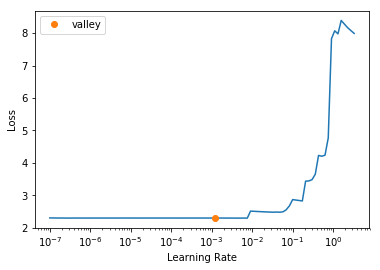

In [7]:
learn.lr_find()

In [10]:
learn.fit_one_cycle(10, 0.0012)

epoch,train_loss,valid_loss,accuracy,time
0,1.742131,1.700102,0.358750,00:06
1,1.466389,1.455805,0.470583,00:06
2,1.332104,1.312778,0.530000,00:06
3,1.209118,1.291064,0.538750,00:06
4,1.087706,1.233198,0.564583,00:07
5,0.907082,1.114381,0.622583,00:07
6,0.696815,1.104822,0.640667,00:06
7,0.512612,1.166674,0.652250,00:06
8,0.340178,1.334792,0.650667,00:06
9,0.241108,1.429086,0.651500,00:07


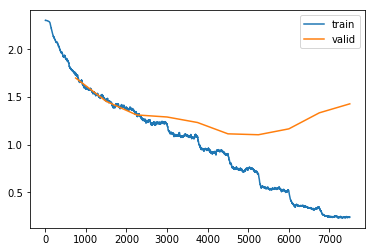

In [11]:
learn.recorder.plot_loss()

SuggestedLRs(valley=7.585775892948732e-05)

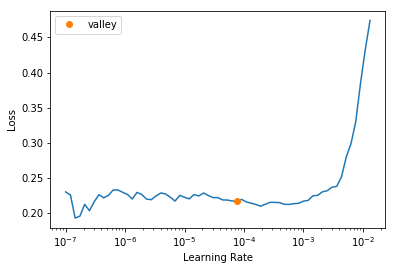

In [9]:
learn.lr_find()

In [10]:
learn.fit_one_cycle(5, 7.6e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.238667,1.545658,0.644167,00:08
1,0.223876,1.670908,0.640417,00:08
2,0.170746,1.799189,0.640833,00:08
3,0.119325,1.948710,0.642083,00:08
4,0.104145,1.987843,0.641583,00:08


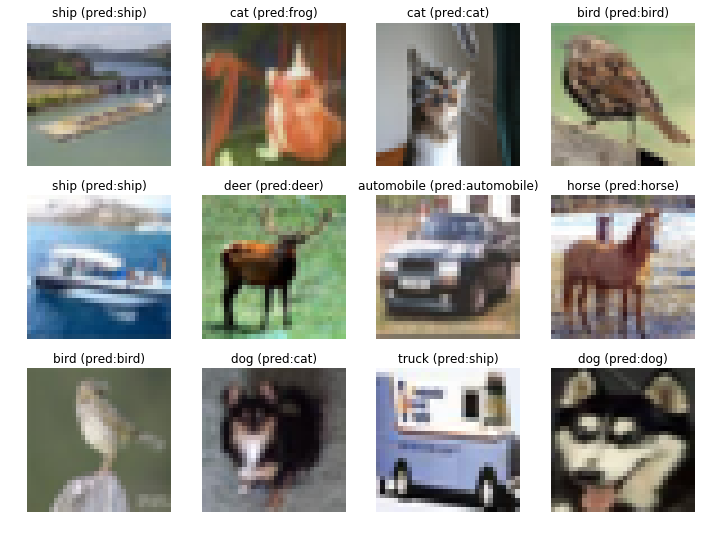

In [165]:
b= dls.valid_ds[np.random.permutation(len(dls.valid_ds))[:12]]
show_grid(dls, [img for img,label in b], [f'{dls.vocab[label]} (pred:{learn.predict(img)[0]})' for img,label in b])

In [164]:
b= dls.valid_ds[np.random.permutation(len(dls.valid_ds))[:12]]
b_imgs,b_labels= [img for img,label in b], [label for img,label in b]
# dls.decode(b[0])
# dls.decode((b_imgs[0],None))
# dls.decode_batch(b)  #Does not work.
# torch.tensor(b_imgs)
# b_imgs[0].permute((2,0,1)).shape
# learn.predict(b_imgs[0])  #Works
# learn.predict(torch.stack(b_imgs))  #Doesn't work
# b_imgs[0].unsqueeze(0).shape
# learn.predict(b_imgs[0].unsqueeze(0))  #Doesn't work
# net(b_imgs[0])  #Doesn't work
# net.to('cpu')
# dls.after_batch(dls.before_batch(dls.after_item(b_imgs[0]))).shape
# net(b_imgs[0].unsqueeze(0))  #Doesn't work
# net(b_imgs[0].view((1,)+b_imgs[0].shape))
# type(b_imgs[0])
# show_grid(dls, [img for img,label in b], [f'{dls.vocab[label]} (pred:{learn.predict(img)[0]})' for img,label in b])

print('learn.predict=',learn.predict(b_imgs[0]))

net.to('cpu')
net.eval()
with torch.no_grad():
    pred= torch.nn.functional.softmax(net(dls.after_batch(dls.before_batch(dls.after_item(b_imgs[0]))).unsqueeze(0)),dim=1)
    print('net=',dls.vocab[pred.max(1).indices.item()], pred.max(1).indices.item(), pred)


learn.predict= ('deer', tensor(4), tensor([1.6061e-05, 6.4661e-09, 8.6283e-02, 4.6489e-03, 8.2243e-01, 7.8156e-02,
        3.0506e-03, 5.4150e-03, 1.0094e-06, 3.1451e-07]))
net= deer 4 tensor([[1.6061e-05, 6.4661e-09, 8.6283e-02, 4.6489e-03, 8.2243e-01, 7.8157e-02,
         3.0506e-03, 5.4150e-03, 1.0094e-06, 3.1451e-07]])


In [163]:
b= dls.valid_ds[np.random.permutation(len(dls.valid_ds))[:12]]
b_imgs,b_labels= [img for img,label in b], [label for img,label in b]

preds,_,dec_preds= learn.get_preds(dl=learn.dls.test_dl(b_imgs), with_decoded=True)
# print(preds)
print(f'learn.get_preds= {dec_preds}')

net.to('cpu')
net.eval()
with torch.no_grad():
    preds= net(torch.stack([dls.after_batch(dls.before_batch(dls.after_item(img))) for img in b_imgs]))
    preds= torch.nn.functional.softmax(preds,dim=1)
    # print(dls.vocab[preds.max(1).indices.item()], preds.max(1).indices.item(), preds)
    print(f'net= {preds.max(1).indices}')

learn.get_preds= tensor([6, 6, 3, 1, 4, 7, 7, 5, 6, 5, 1, 7])
net= tensor([6, 6, 3, 1, 4, 7, 7, 5, 6, 5, 1, 7])


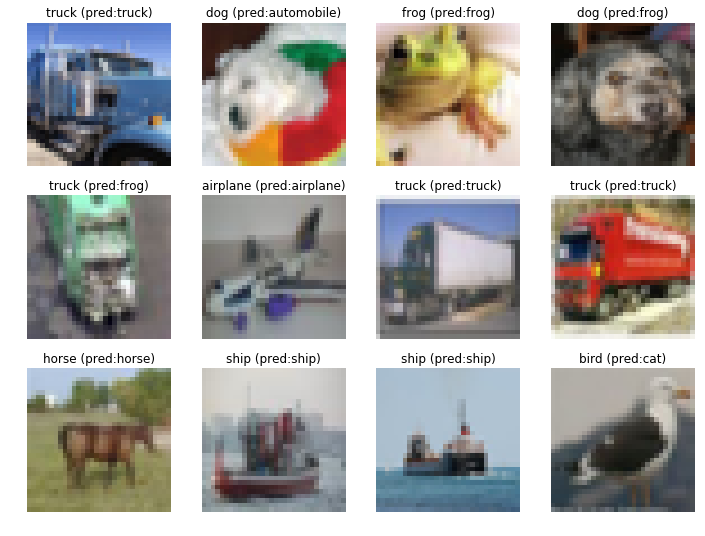

In [167]:
b= dls.valid_ds[np.random.permutation(len(dls.valid_ds))[:12]]
b_imgs,b_labels= [img for img,label in b], [label for img,label in b]
preds,_,dec_preds= learn.get_preds(dl=learn.dls.test_dl(b_imgs), with_decoded=True)
show_grid(dls, b_imgs, [f'{dls.vocab[label]} (pred:{dls.vocab[pred_label]})' for label,pred_label in zip(b_labels,dec_preds)])